# MC-Dropout (Monte Carlo Dropout)

In this notebook, we use **Monte Carlo Dropout (MC-Dropout)** to estimate uncertainty in our Bayesian Convolutional Neural Network (BCNN) model.

MC-Dropout consists of keeping dropout active during inference and performing multiple forward passes with different random dropout masks. This allows us to obtain a distribution of predictions that reflects the model’s uncertainty when faced with new data.

The advantages MC-Dropout offers us include:

* It is a simple and efficient method that can be easily applied to existing models without modifying their architecture.
* It enables uncertainty estimation, which is very useful for identifying ambiguous or out-of-distribution samples.

It is important to highlight that MC-Dropout is **not deterministic**, since the random activation of neurons in each pass generates variability and allows us to model the uncertainty of the network.

### Motivation: Why Uncertainty Estimation is important for Fake Image Detection

The **confidence** or **uncertainty** associated with that prediction is equally, if not more, important. Consider these scenarios:

* **Sophisticated Fakes:** A fake image might be so well-generated that it nearly fools the model. High uncertainty in this case could be a flag indicating a potentially advanced adversarial example.
* **Ambiguous Content:** Some images might inherently possess characteristics of both real and fake images, or be of a style the model hasn't seen extensively.
* **Out-of-Distribution (OOD) Samples:** If the model encounters an image vastly different from its training data, it should ideally express high uncertainty rather than making a confident (and likely wrong) prediction.

MC-Dropout provides a practical way for our `BayesianCNN` to quantify this prediction uncertainty. This allows for more nuanced decision making for instance, predictions with high uncertainty might be flagged for human review or indicate areas where the model needs further training.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
import pandas as pd

In [ ]:
# Bayesian CNN 
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # CIFAKE: real vs fake

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [37]:
#with this we can resize the images 64x64 pixeles
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# charge the subdirectories as classes (Fake class 0 and Real class1)
trainset = datasets.ImageFolder(root='./data/train', transform=transform)
testset = datasets.ImageFolder(root='data/test', transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

### Training Dynamics for REAL/FAKE Classification

The training process iteratively adjusts the weights of our `BayesianCNN` to better distinguish between REAL and FAKE images from the CIFAKE dataset. Let's highlight key components specific to this task:

* **Loss Calculation (`criterion = nn.CrossEntropyLoss()`):** For each batch of images, the `CrossEntropyLoss` compares the model's output logits (raw scores for FAKE and REAL classes) against the true labels. This loss function is standard for classification tasks and implicitly includes a Softmax activation. It penalizes the model more heavily for confident incorrect predictions. A lower loss value indicates better agreement between the model's predictions and the ground truth on the training set.

* **Weight Updates (`optimizer.step()`):** The **Adam optimizer** uses the calculated loss to determine how to adjust the model's weights (in `conv1`, `conv2`, `fc1`, `fc2`). It aims to find a set of weights that minimizes the overall loss, effectively making the model better at identifying patterns that differentiate REAL from FAKE images.

In [38]:
#Train the BCNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianCNN().to(device) #here we are putting the model in training mode
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # Forward pass 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

# During training, the model works as a normal network with Dropout activated.
# The special aspect of MC-Dropout is that during inference we keep Dropout active, performing multiple forward passes
# to capture uncertainty, variability, and compute mean, variance, and entropy.

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [06:47<00:00,  3.84it/s]


Epoch 1, Loss: 0.3892


100%|██████████| 1563/1563 [07:34<00:00,  3.44it/s]


Epoch 2, Loss: 0.2867


100%|██████████| 1563/1563 [06:44<00:00,  3.87it/s]


Epoch 3, Loss: 0.2467


100%|██████████| 1563/1563 [06:30<00:00,  4.01it/s]


Epoch 4, Loss: 0.2176


100%|██████████| 1563/1563 [06:19<00:00,  4.12it/s]

Epoch 5, Loss: 0.1983


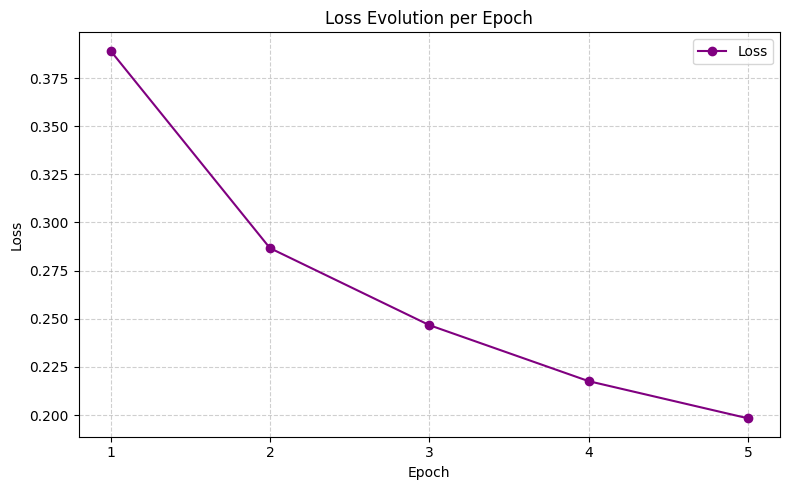

In [60]:
epochs = [1, 2, 3, 4, 5]
losses = [0.3892, 0.2867, 0.2467, 0.2176, 0.1983]

plt.figure(figsize=(8,5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='purple', label='Loss')

plt.title('Loss Evolution per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Training minimizes the **cross-entropy loss function**:

$$
\text{Loss} = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

where $y_i$ is the real label and $\hat{y}_i$ is the predicted probability for class $i$. To optimize the model parameters $\theta$, we use Adam, which updates weights adaptively according to:

$$
\theta^{(t+1)} = \theta^{(t)} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

with $\hat{m}_t$ and $\hat{v}_t$ being adaptive moments of the gradient.

During inference, we use **MC-Dropout** by keeping dropout active and performing $T$ forward passes to compute the predictive mean and variance to estimate uncertainty:

$$
\mu = \frac{1}{T} \sum_{t=1}^T \hat{y}^{(t)}, \quad \sigma^2 = \frac{1}{T} \sum_{t=1}^T \hat{y}^{(t)2} - \mu^2
$$

The loss steadily decreases from about 0.469 to 0.15 over 10 epochs, indicating the model is better fitting its predictions to the true labels. Adam optimization facilitates this adaptive fitting. Also, MC-Dropout lets the model not only learn but also measure uncertainty in its predictions, making it more robust and reliable for new or difficult data.


In [41]:
torch.save(model.state_dict(), 'bayesian_cnn_weights.pth')
print("Weight saved")
model = BayesianCNN()  
model.load_state_dict(torch.load('bayesian_cnn_weights.pth'))
model.eval()  


Weight saved


BayesianCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Our BayesianCNN architecture consists of two consecutive convolutional layers: the first layer (`conv1`) takes RGB images with 3 channels and applies 32 filters of size 3x3 with padding to preserve spatial dimensions; the second layer (`conv2`) increases the depth to 64 filters, also of size 3x3 with padding. After each convolution, a max pooling layer with a 2x2 kernel and stride 2 reduces the spatial resolution by half, facilitating feature extraction and reducing computational load. The resulting output is flattened and fed into a fully connected layer (`fc1`) with 128 neurons, which integrates the extracted features. Finally, an output linear layer (`fc2`) projects these features into two classes for binary classification. The inclusion of a Dropout layer with a probability of 0.5, applied after the dense layer and kept active during inference, enables Monte Carlo Dropout to approximate predictive uncertainty in a Bayesian manner.

As we have studied during the course, using standard Monte Carlo we can estimate expectations through direct sampling. These samples are independent from a known distribution $p(x)$, meaning they are also independent from each other. This estimation is given by the following formula:

$$
\mathbb{E}[f(x)] = \int f(x) p(x) dx \approx \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$

where $x_i$ are direct, independent samples from $p(x)$.
With this basic concept, we can introduce Monte Carlo Dropout, which, unlike standard Monte Carlo, performs multiple forward passes through the network with Dropout activated.
Dropout is a regularization technique for neural networks that randomly deactivates certain neurons during training, preventing the network from relying too much on specific neurons and reducing overfitting.
During the training phase, each neuron or activation layer is assigned a probability of being turned off (set to zero), as follows:

$$
\tilde{h}_{i} = h_i \cdot z_i
$$

where $z_i \sim \text{Bernoulli}(1-p)$.
During inference (prediction), this Dropout is typically deactivated.

However, in MC-Dropout, we keep Dropout active during inference to obtain multiple predictions:

$$
\mathbb{E}[f(x; \theta)] \approx \frac{1}{T} \sum_{t=1}^{T} f(x; \theta_t)
$$

where:

* $\theta_t$ is the network with a **different random Dropout mask** at each pass.
* This allows us to capture the **variability of predictions** due to Dropout randomness.

In our project, we decided to use MC-Dropout because it allows us to estimate uncertainty in a practical and efficient way, simply by performing multiple inferences with Dropout activated. Additionally, it is much faster and easier to implement than heavier Bayesian methods such as MCMC, without the need to modify the network architecture.




In [42]:
def enable_dropout(m):
    #Enable dropout layers during inference
    for module in m.modules():
        if isinstance(module, nn.Dropout):
            module.train()

#Make T forward passes with an active dropout
#and return the prediction of the mean, enthropy and the variance. 
def mc_dropout_predict(model, image_tensor, T=30):
    model.eval()
    enable_dropout(model)

    preds = []
    with torch.no_grad():
        for _ in range(T):
            output = model(image_tensor) # f(x; 0_t) 
            prob = F.softmax(output, dim=1)
            preds.append(prob.unsqueeze(0))
    
    # Shape: [T, batch_size, num_classes]
    preds = torch.cat(preds, dim=0)  
    # Shape: [batch_size, num_classes]
    mean_probs = preds.mean(dim=0)
    # Shape: [batch_size, num_classes]
    var_probs = preds.var(dim=0)
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-8), dim=1)
    
    return mean_probs, var_probs, entropy

In addition to using MC-Dropout to obtain multiple predictions per image, we also calculated some metrics such as **mean prediction**, **variance**, and **entropy**. These metrics allow us to not only classify the images as real or fake but also to quantify how confident the model is about its predictions.

* **Mean Prediction**: we compute the average of the predictions from $T$ stochastic forward passes:

$$
\mu = \frac{1}{T} \sum_{t=1}^{T} \hat{y}_t
$$

* **Variance**: we calculate the variance across the predictions, which reflects the **epistemic uncertainty** of the model:

$$
\sigma^2 = \frac{1}{T} \sum_{t=1}^{T} (\hat{y}_t - \mu)^2
$$

* **Predictive Entropy**: we also calculate the predictive entropy, which measures the uncertainty over the output distribution itself:

$$
H[\hat{y}] = - \sum_{c=1}^{C} \bar{p}_c \log \bar{p}_c
$$

where $\bar{p}_c$ is the mean predicted probability for class $c$ (class 1 real, class 0 fake) over the $T$ passes (it's tha name of time that you pass across one image).




In [ ]:
model.to(device)
model.eval()

results = []
threshold = 0.5  
sample_index = 0

with torch.no_grad():
    for inputs, labels in tqdm(testloader):
        inputs = inputs.to(device)

        # MC-Dropout Prediction with T forward passes
        mean_probs, var_probs, entropy = mc_dropout_predict(model, inputs, T=30)

        batch_size = inputs.size(0)
        for i in range(batch_size):
            prob_real = mean_probs[i, 1].item()
            pred_class = 1 if prob_real -- threshold else 0

        
            filename = testset.samples[sample_index][0].split('/')[-1]
            sample_index += 1

            results.append({
                'filename': filename,
                'true_label': labels[i].item(),
                'prediction': 'REAL' if pred_class == 1 else 'FAKE',
                'prob_real': prob_real,
                'epistemic_uncertainty_mean': var_probs[i].cpu().numpy().mean(),
                'predictive_entropy': entropy[i].item()
            })

df = pd.DataFrame(results)
df.to_csv('test_results.csv', index=False)
print(df.head())



100%|██████████| 313/313 [19:05<00:00,  3.66s/it]


               filename  true_label prediction  prob_real  \
0  test\FAKE\0 (10).jpg           0       FAKE   0.013859   
1   test\FAKE\0 (2).jpg           0       FAKE   0.082013   
2   test\FAKE\0 (3).jpg           0       FAKE   0.018401   
3   test\FAKE\0 (4).jpg           0       FAKE   0.003915   
4   test\FAKE\0 (5).jpg           0       FAKE   0.108048   

   epistemic_uncertainty_mean  predictive_entropy  
0                    0.001466            0.073061  
1                    0.007797            0.283658  
2                    0.003254            0.091749  
3                    0.000092            0.025611  
4                    0.007927            0.342414  


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Load the test results
df = pd.read_csv('test_results.csv')

# Map the prediction labels from text to numeric (0 = FAKE, 1 = REAL) to make analysis easier
df['pred_label'] = df['prediction'].map({'FAKE': 0, 'REAL': 1})

# Quick confusion matrix with counts
conf_matrix = pd.crosstab(df['true_label'], df['pred_label'], 
                          rownames=['True'], colnames=['Predicted'])

print("Confusion Matrix (counts):")
print(conf_matrix)

true_fake_pred_fake = ((df['true_label'] == 0) & (df['pred_label'] == 0)).sum()
true_fake_pred_real = ((df['true_label'] == 0) & (df['pred_label'] == 1)).sum()
true_real_pred_real = ((df['true_label'] == 1) & (df['pred_label'] == 1)).sum()
true_real_pred_fake = ((df['true_label'] == 1) & (df['pred_label'] == 0)).sum()


Confusion Matrix (counts):
Predicted     0     1
True                 
0          9322   678
1           757  9243


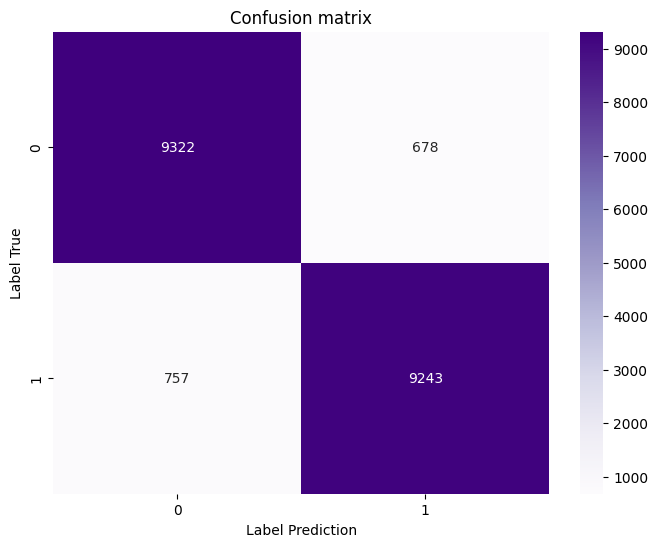

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_matrix_data = np.array([[true_fake_pred_fake, true_fake_pred_real],
                                  [true_real_pred_fake,  true_real_pred_real]])
labels = ['0', '1']

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion matrix')
plt.ylabel('Label True')
plt.xlabel('Label Prediction')

plt.show()

In [7]:
# Calculate standard classification metrics
precision = precision_score(df['true_label'], df['pred_label'])
recall = recall_score(df['true_label'], df['pred_label'])
f1 = f1_score(df['true_label'], df['pred_label'])

precision_fake = precision_score(df['true_label'], df['pred_label'], pos_label=0)
recall_fake = recall_score(df['true_label'], df['pred_label'], pos_label=0)
f1_fake = f1_score(df['true_label'], df['pred_label'], pos_label=0)

print(f"\nMetrics for REAL class:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")

print(f"\nMetrics for FAKE class:")
print(f"  Precision: {precision_fake:.4f}")
print(f"  Recall:    {recall_fake:.4f}")
print(f"  F1-score:  {f1_fake:.4f}")

accuracy = accuracy_score(df['true_label'], df['pred_label'])
print(f"\nModel Accuracy: {accuracy:.4f}")


Metrics for REAL class:
  Precision: 0.9317
  Recall: 0.9243
  F1-score: 0.9280

Metrics for FAKE class:
  Precision: 0.9249
  Recall:    0.9322
  F1-score:  0.9285

Model Accuracy: 0.9283


The confusion matrix shows the model correctly classified 9322 fake images and 9243 real images. It misclassified 678 fake images as real, and 757 real images as fake. For the **REAL class**, precision is 0.9317 and recall is 0.9243, meaning that when the model predicts REAL, it is right 93.17% of the time, and it detects 92.43% of all real images. For the **FAKE class**, precision is 0.9249 and recall is 0.9322, which means predictions of FAKE are correct 92.49% of the time, and 93.22% of fake images are found.

The **F1-scores** for both classes are similar (around 0.928), reflecting a balanced performance.

Overall **accuracy** is 0.9283, showing the model labels correctly 92.83% of the test images.

We notice the model performs similarly on both classes, with small differences between precision and recall. The errors are fairly balanced, so no strong bias toward one class. This helps us trust the classification is stable but leaves room for improving borderline cases or threshold tuning.


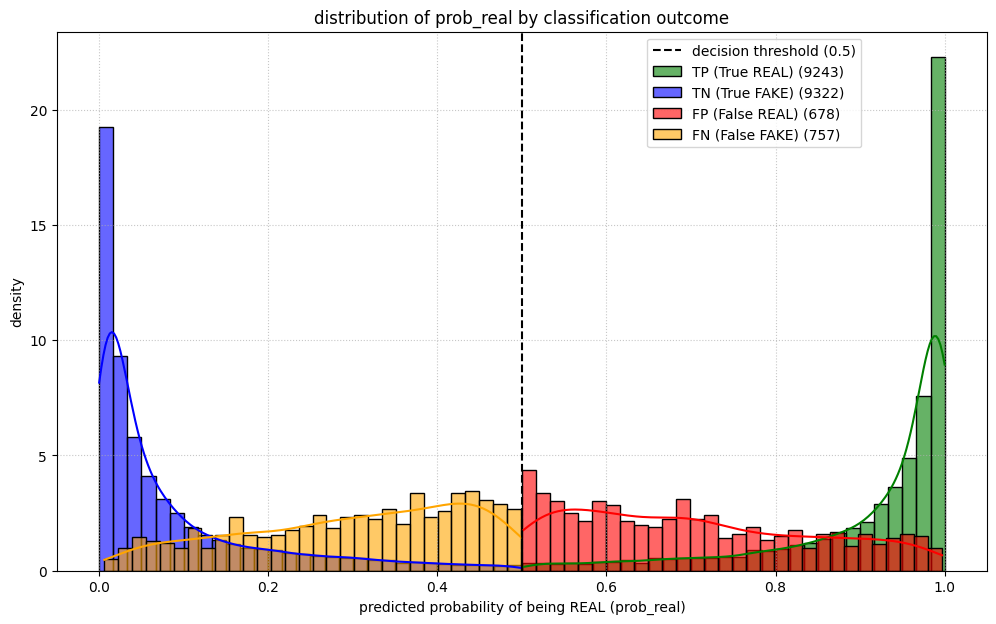

In [9]:
def get_classification_outcome(row):
    if row['true_label'] == 1 and row['pred_label'] == 1: return 'TP (True REAL)'
    if row['true_label'] == 0 and row['pred_label'] == 0: return 'TN (True FAKE)' # Corrected from VN to TN for consistency
    if row['true_label'] == 0 and row['pred_label'] == 1: return 'FP (False REAL)' # Type I Error
    if row['true_label'] == 1 and row['pred_label'] == 0: return 'FN (False FAKE)' # Type II Error
    return 'Other'

df['classification_outcome'] = df.apply(get_classification_outcome, axis=1)

plt.figure(figsize=(12, 7))
outcomes_to_plot = ['TP (True REAL)', 'TN (True FAKE)', 'FP (False REAL)', 'FN (False FAKE)']
colors = ['green', 'blue', 'red', 'orange']

for i, outcome in enumerate(outcomes_to_plot):
    subset = df[df['classification_outcome'] == outcome]
    if not subset.empty:
        sns.histplot(subset['prob_real'], bins=30, label=f"{outcome} ({len(subset)})", color=colors[i], kde=True, stat="density", common_norm=False, alpha=0.6)

plt.title('distribution of prob_real by classification outcome')
plt.xlabel('predicted probability of being REAL (prob_real)')
plt.ylabel('density')
plt.axvline(0.5, color='black', linestyle='--', label='decision threshold (0.5)')
plt.legend(loc='upper center', bbox_to_anchor=(0.75,1))
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

This graph shows us how the `prob_real` that's the probability our model gives for an image being REAL is spread out for different types of correct and incorrect predictions.

* **True Negatives (TN - Blue curve):** These are the *FAKE* images that our model correctly identified as *FAKE*. As we'd hope, most of these have a `prob_real` close to 0. This is good; it means the model is pretty confident when it correctly spots a fake.
* **True Positives (VP - Green curve):** These are the *REAL* images that our model correctly identified as *REAL*. These mostly have a `prob_real` close to 1. This is also good; the model is confident when it correctly spots a real image.
* **Separation:** The blue and green curves are quite far apart, with the decision line (at 0.5) sitting nicely in between. This shows our model is generally doing a decent job of telling the two classes apart.
* **False Positives (FP - Red curve):** These are *FAKE* images that our model mistakenly called *REAL*. We can see these errors mostly happen when the `prob_real` is somewhere between 0.5 and about 0.8. So, when the model makes this kind of mistake, it's not usually with extreme confidence, but rather when it's leaning towards *REAL* without being absolutely certain.
* **False Negatives (FN - Orange curve):** These are *REAL* images that our model mistakenly called *FAKE*. These errors are kind of the mirror image of the FPs, mostly occurring when `prob_real` is between about 0.2 and 0.5. Again, these mistakes tend to happen when the model is leaning towards *FAKE* but isn't completely sure.

So, what this tells me is that our model is pretty good at being confident about its correct predictions. When it makes mistakes, it tends to be in that middle zone of probability, where it's not overwhelmingly sure one way or the other. This is useful to know because it highlights the types of situations where our model is more likely to get things wrong.